# <u>Gender Detection Model</u>

In [1]:
# Importing Basic Libraries
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Pre-Processing
I am using `ImageDataGenerator()` class from `tensorflow.keras.preprocessing.image` module to load files from my working directory. If you're not using this in your system and working over cloud-based notebook(which I would recommend if you don't have your GPU configured with Tensorflow or it can take hours to train💀), you'd need to upload the Test,Train and Validation folders.  
After loading the data I am resizing the image to 100X100 pixels to maintain uniformity in the number of pixels of image.  
  
I am using this class because there're a lots of beniffits assciated-
- Loads a batch of image in memory at a time making it efficient
- We can use transformations like random rotations,flip,zoom etc. to improve model generalisation(Since this data set was already diverse, I didn't use any of them)
- Seamless integration as it can be directly used in `fit()` function. It automatically encodes the labels based on the input directory structure and selected class_mode.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Declaring image size
image_size = (100, 100)


datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    fill_mode='nearest'
    )

# Creating the data generators for each dataset
train_generator = datagen.flow_from_directory(
    'Dataset/Train',
    target_size=image_size,
    batch_size=16,
    class_mode='binary'  # Choosing binary classification (male vs female) this will result in binary encoded labels. For multiple classes we can use 'categorical' which would one hot encode the labels.
)

validation_generator = datagen.flow_from_directory(
    'Dataset/Validation',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    'Dataset/Test',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Checking the number of samples
print(f"Training data size: {train_generator.samples}")
print(f"Validation data size: {validation_generator.samples}")
print(f"Test data size: {test_generator.samples}")


Found 8000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Training data size: 8000
Validation data size: 500
Test data size: 1000


In [4]:
train_generator.image_shape

(100, 100, 3)

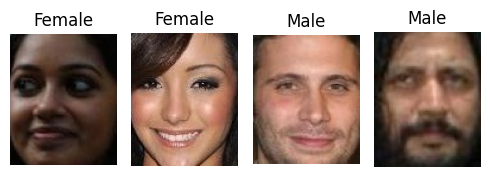

In [5]:
# Here I tried to show randomly two data from each class male and female with their labels to get an idea about how our data set looks like

# Getting the names of classes(in this case ['Male','Female'])
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(5, 5))

# Looping over each class and plotTing 2 random images
for class_index, class_name in enumerate(class_names):

    # Getting the file paths of the images in selected class
    image_paths = [file for file, label in zip(train_generator.filenames, train_generator.classes) if label == class_index]
    
    # Randomly selecting 2 images
    selected_images = np.random.choice(image_paths, 2, replace=False)
    
    # Plotting the images
    for i, image_path in enumerate(selected_images):

        img = plt.imread(train_generator.directory + '/' + image_path)
        
        plt.subplot(1,4, class_index * 2 + i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        plt.title(class_name)
        
plt.tight_layout()
plt.show()

Since the images in the dataset are already highly cropped to face as we can see in the output of previous cell, so we need not use the face detection tools to crop out the face

### Building and Training Model
##### Structure of model
In the following cells I built a **sequential** model in which number of convulations, kernels in them, MaxPooling and  no. of fully connected layers are selected through hit and trial by constantly changing the numbers and checking the accuracy.
- I used **5 convolution layers** consisting of **32, 64, 64, 128 and 128 kernels respectively** of shape `(3,3)` the first and third followed by **max pooling layers of shape** `(3,3)` and `(2,2)` respectively. The Activation function used was **ReLU**.
- After the fifth convolution I **flattened the images** into a 1D vector  of size `16*16*128=32768` to be fed into a fully connected layer.
- After flattening I used a **dense layers** with **1024 neurons** and **ReLU** activation function for further processing.
- Since in my initial trials my model was performing well over the training data but lower on testing data, so to prevent overfitting I introduced some **dropout layers** to capture more robust features.
- Finally the output layer has 1 unit and uses **sigmoid** activation function.
##### Compilation of Model
- I went with **Adam optimizer** for adaptive learning rate of the model.
- For loss function I used **binary cross entropy**
- And training metrics is selected to be **accuracy**
##### Training of Model
For training I went with 30 epochs which I found the beast balance between time and accuracy for my model by hit and trial. Followed by saving the assets of model to be saved in `gender_detection.model` to avoid retraining on kernel restart.

In [ ]:
# Building model
model = keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(100,100,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(128,(3,3),activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Flatten(),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


# Checking model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 33, 33, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 33, 33, 64)       2

In [7]:
# Compiling Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

In [ ]:
# Training and Saving the model
history=model.fit(train_generator,epochs=30,validation_data=validation_generator)
model.save('gender_detection.model')

Epoch 1/30
500/500 [==============================] - 107s 196ms/step - loss: 0.5153 - accuracy: 0.8048 - val_loss: 0.2782 - val_accuracy: 0.8800
Epoch 2/30
500/500 [==============================] - 19s 37ms/step - loss: 0.3184 - accuracy: 0.8736 - val_loss: 0.2791 - val_accuracy: 0.8760
Epoch 3/30
500/500 [==============================] - 19s 37ms/step - loss: 0.2781 - accuracy: 0.8839 - val_loss: 0.2143 - val_accuracy: 0.9280
Epoch 4/30
500/500 [==============================] - 19s 37ms/step - loss: 0.2317 - accuracy: 0.9130 - val_loss: 0.1762 - val_accuracy: 0.9300
Epoch 5/30
500/500 [==============================] - 19s 37ms/step - loss: 0.2159 - accuracy: 0.9166 - val_loss: 0.1869 - val_accuracy: 0.9320
Epoch 6/30
500/500 [==============================] - 19s 37ms/step - loss: 0.2222 - accuracy: 0.9145 - val_loss: 0.2320 - val_accuracy: 0.9340
Epoch 7/30
500/500 [==============================] - 19s 37ms/step - loss: 0.1924 - accuracy: 0.9305 - val_loss: 0.3544 - val_accurac

INFO:tensorflow:Assets written to: gender_detection.model\assets


INFO:tensorflow:Assets written to: gender_detection.model\assets


### Testing and Evaluation
I tested my model on 1000 unseen data evaluating the loss and accuracy of the model, further followed by plotting a `confusion matrix` with the help of `sckit-learn` for more visualisation of accuracy and errors.

In [9]:
results=model.evaluate(test_generator)
print("The loss for testing data comes out to be:",results[0])
print("The accuracy for testing data comes out to be:",results[1]*100,"%")

32/32 [==============================] - 3s 76ms/step - loss: 0.1209 - accuracy: 0.9550
The loss for testing data comes out to be: 0.12094373255968094
The accuracy for testing data comes out to be: 95.49999833106995 %


32/32 [==============================] - 2s 55ms/step


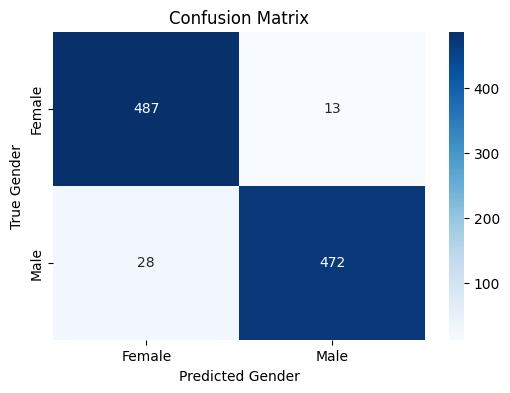

In [ ]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int)


true_labels = test_generator.classes

# Creating confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels[:len(predicted_labels)], predicted_labels)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted Gender')
plt.ylabel('True Gender')
plt.title('Confusion Matrix')
plt.savefig("Confusion-Matrix.png")
plt.show()